This dataset contains detailed records of yellow taxi trips in New York City during January 2023

Rows: 3,066,766
Columns: 19



In [12]:
import cudf
import cuml
import cupy as cp
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.metrics import mean_squared_error
import numpy as np
import tracemalloc
import pandas as pd
import xgboost as xgb
from cuml.preprocessing import StandardScaler
import os




In [13]:
if not os.path.exists('data'):
    os.makedirs('data')


In [14]:
!wget -P data https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet


--2025-04-17 12:42:12--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.239.38.147, 18.239.38.83, 18.239.38.163, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.239.38.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘data/yellow_tripdata_2023-01.parquet’

yellow_tripdata_202 100%[===================>]  45.46M  --.-KB/s    in 0.1s    

2025-04-17 12:42:12 (319 MB/s) - ‘data/yellow_tripdata_2023-01.parquet’ saved [47673370/47673370]




# Load data

In [15]:
!ls data

df = cudf.read_parquet('data/yellow_tripdata_2023-01.parquet')

df.info()
df.head(20)

yellow_tripdata_2023-01.parquet
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype
---  ------                 -----
 0   VendorID               int64
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object
 7   PULocationID           int64
 8   DOLocationID           int64
 9   payment_type           int64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: datetime64[us](2), float64(12), int64(4), object(1)
memory usage: 437.5+ MB


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.00,0.5,10.00,0.0,1.0,27.80,2.5,0.00
6,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,12.1,1.00,0.5,3.42,0.0,1.0,20.52,2.5,0.00
7,2,2023-01-01 00:27:12,2023-01-01 00:49:56,1.0,11.70,1.0,N,142,200,1,45.7,1.00,0.5,10.74,3.0,1.0,64.44,2.5,0.00
8,2,2023-01-01 00:21:44,2023-01-01 00:36:40,1.0,2.95,1.0,N,164,236,1,17.7,1.00,0.5,5.68,0.0,1.0,28.38,2.5,0.00
9,2,2023-01-01 00:39:42,2023-01-01 00:50:36,1.0,3.01,1.0,N,141,107,2,14.9,1.00,0.5,0.00,0.0,1.0,19.90,2.5,0.00


# Explore data


In [16]:
df.shape[0]

3066766

In [17]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,3.066766e+06,3066766,3066766,2.995023e+06,3.066766e+06,2.995023e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,2.995023e+06,2.995023e+06
mean,1.730215e+00,2023-01-17 00:22:26.288164,2023-01-17 00:38:06.427874,1.362532e+00,3.847342e+00,1.497440e+00,1.663980e+02,1.643926e+02,1.194483e+00,1.836707e+01,1.537842e+00,4.882900e-01,3.367941e+00,5.184910e-01,9.820850e-01,2.702038e+01,2.274231e+00,1.074090e-01
min,1.000000e+00,2008-12-31 23:01:42,2009-01-01 14:29:11,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.000000e+02,-7.500000e+00,-5.000000e-01,-9.622000e+01,-6.500000e+01,-1.000000e+00,-7.510000e+02,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,2023-01-09 16:21:57.250000,2023-01-09 16:37:06.000000,1.000000e+00,1.060000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.540000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2023-01-17 08:42:29.500000,2023-01-17 08:58:30.500000,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.720000e+00,0.000000e+00,1.000000e+00,2.016000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2023-01-24 16:26:27.000000,2023-01-24 16:42:49.000000,1.000000e+00,3.330000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.870000e+01,2.500000e+00,0.000000e+00
max,2.000000e+00,2023-02-01 00:56:53,2023-02-02 09:28:47,9.000000e+00,2.589281e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,1.160100e+03,1.250000e+01,5.316000e+01,3.808000e+02,1.969900e+02,1.000000e+00,1.169400e+03,2.500000e+00,1.250000e+00
std,4.438480e-01,<NA>,<NA>,8.961200e-01,2.495838e+02,6.474767e+00,6.424413e+01,6.994368e+01,5.294760e-01,1.780782e+01,1.789592e+00,1.034640e-01,3.826759e+00,2.017579e+00,1.833530e-01,2.216359e+01,7.718450e-01,3.556510e-01


In [18]:
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64

In [19]:

df = df.dropna()
df.isnull().sum()


VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

In [20]:
df.shape[0]

2995023

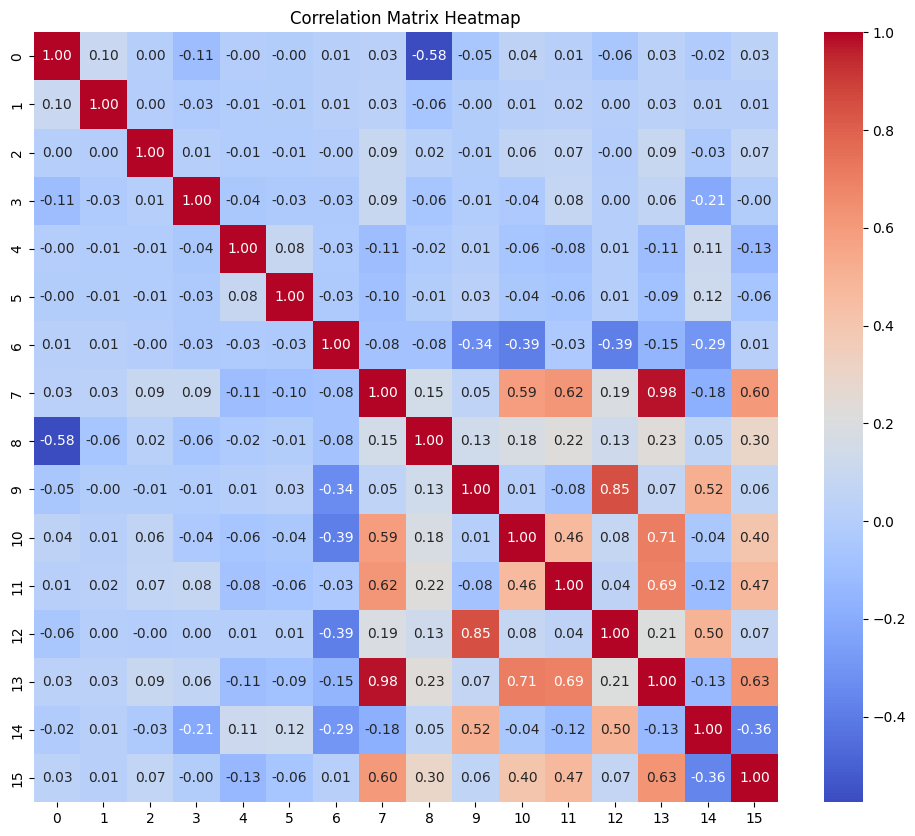

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numerical_cols = df.select_dtypes(include=['number'])

correlation_matrix = numerical_cols.corr()

correlation_matrix_np = correlation_matrix.to_numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_np, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [22]:

df = df.drop(columns=['RatecodeID', 'store_and_fwd_flag', 'VendorID', 'PULocationID','DOLocationID','store_and_fwd_flag','payment_type','improvement_surcharge','mta_tax'])

df.info()


<class 'cudf.core.dataframe.DataFrame'>
Index: 2995023 entries, 0 to 2995022
Data columns (total 11 columns):
 #   Column                 Dtype
---  ------                 -----
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64
 3   trip_distance          float64
 4   fare_amount            float64
 5   extra                  float64
 6   tip_amount             float64
 7   tolls_amount           float64
 8   total_amount           float64
 9   congestion_surcharge   float64
 10  airport_fee            float64
dtypes: datetime64[us](2), float64(9)
memory usage: 274.2 MB


In [23]:
df['trip_duration'] = (cudf.to_datetime(df['tpep_dropoff_datetime']) - cudf.to_datetime(df['tpep_pickup_datetime'])).dt.total_seconds()

In [24]:
df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [25]:
X = df.drop('total_amount', axis=1)
y = df['total_amount']

In [26]:
X

,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount,congestion_surcharge,airport_fee,trip_duration
0,1.0,0.97,9.3,1.00,0.00,0.0,2.5,0.00,506.0
1,1.0,1.10,7.9,1.00,4.00,0.0,2.5,0.00,379.0
2,1.0,2.51,14.9,1.00,15.00,0.0,2.5,0.00,765.0
3,0.0,1.90,12.1,7.25,0.00,0.0,0.0,1.25,577.0
4,1.0,1.43,11.4,1.00,3.28,0.0,2.5,0.00,650.0
...,...,...,...,...,...,...,...,...,...
2995018,1.0,13.90,50.5,0.00,0.00,0.0,0.0,0.00,4094.0
2995019,1.0,3.37,15.6,1.00,2.00,0.0,2.5,0.00,652.0
2995020,1.0,2.86,16.3,1.00,2.00,0.0,2.5,0.00,834.0
2995021,2.0,3.80,17.7,3.50,2.50,0.0,2.5,0.00,646.0


In [27]:
y

0          14.30
1          16.90
2          34.90
3          20.85
4          19.68
           ...  
2995018    52.00
2995019    22.60
2995020    23.30
2995021    25.20
2995022    10.80
Name: total_amount, Length: 2995023, dtype: float64

In [28]:
X = cudf.DataFrame.from_pandas(X)
y = cudf.Series.from_pandas(y)

/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:5571: FutureWarning: Support for loading dataframes via the `__dataframe__` interchange protocol is deprecated
  warnings.warn(


## Scale data

In [29]:
from cuml.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
joblib.dump(scaler, 'scalar.joblib')



['scalar.joblib']

# Split data


In [32]:
from cuml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


X_train = X_train[1:150000]
y_train = y_train[1:150000]

X_test = X_test[1:150000]
y_test = y_test[1:150000]

sample_size = 5000
X_test_sample = X_test.sample(n=sample_size, random_state=42)  # Use random_state for reproducibility

X_test_sample.to_csv('X_test_sample.csv', index=False)

# Random Forest Regressor

In [33]:
import time
from cuml.metrics import r2_score
import joblib

start_time = time.time()
tracemalloc.start()



model = cuml.ensemble.RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred_rf  = model.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time
end_time = time.time()
execution_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()

mse_rf = mean_squared_error(y_test, y_pred_rf )
rmse_rf = mse_rf**0.5
r2_rf = r2_score(y_test, y_pred_rf )

print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared (R2): {r2_rf}")


tracemalloc.stop()

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Execution Time: 1.33 seconds
Current memory usage: 0.09 MB; Peak: 0.47 MB
Mean Squared Error (MSE): 25.883279706237495
Root Mean Squared Error (RMSE): 5.087561272971314
R-squared (R2): 0.94786059938692


# XGb

In [36]:
start_time = time.time()
tracemalloc.start()

dtrain = xgb.DMatrix(X_train.to_pandas(), label=y_train.to_pandas())
dtest = xgb.DMatrix(X_test.to_pandas(), label=y_test.to_pandas())

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'eval_metric': 'rmse'
}

model = xgb.train(params, dtrain)
y_pred = model.predict(dtest)
y_pred_xgb_cudf  = cudf.Series(y_pred)

end_time = time.time()
execution_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()

mse_xgb = mean_squared_error(y_test, y_pred_xgb_cudf )
rmse_xgb = mse_xgb**0.5
r2_xgb = r2_score(y_test, y_pred_xgb_cudf )

print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"R-squared (R2): {r2_xgb}")

joblib.dump(model, 'model.joblib')


tracemalloc.stop()

Execution Time: 0.35 seconds
Current memory usage: 0.66 MB; Peak: 33.65 MB
Mean Squared Error (MSE): 11.909826574714968
Root Mean Squared Error (RMSE): 3.451061659071737
R-squared (R2): 0.9760087892238122


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


# KNeighbors Regressor

In [35]:
from cuml.neighbors import KNeighborsRegressor

start_time = time.time()
tracemalloc.start()

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)
y_pred_knn = model.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = mse_knn**0.5
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")
print(f"Mean Squared Error (MSE): {mse_knn}")
print(f"Root Mean Squared Error (RMSE): {rmse_knn}")
print(f"R-squared (R2): {r2_knn}")

joblib.dump(model, 'knn_model.joblib')

tracemalloc.stop()

Execution Time: 2.50 seconds
Current memory usage: 0.06 MB; Peak: 0.45 MB
Mean Squared Error (MSE): 2.871925338510578
Root Mean Squared Error (RMSE): 1.6946755850340731
R-squared (R2): 0.9942147800643915


# Logistic Regression

In [37]:
from cuml.linear_model import LogisticRegression
import time
import tracemalloc
from cuml.metrics import mean_squared_error, r2_score
import joblib


start_time = time.time()
tracemalloc.start()

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_logistic = model.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()

mse_logistic = mean_squared_error(y_test, y_pred_logistic)
rmse_logistic = mse_logistic**0.5
r2_logistic = r2_score(y_test, y_pred_logistic)

print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")
print(f"Mean Squared Error (MSE): {mse_logistic}")
print(f"Root Mean Squared Error (RMSE): {rmse_logistic}")
print(f"R-squared (R2): {r2_logistic}")

joblib.dump(model, 'logistic_model.joblib')

tracemalloc.stop()

[2025-04-17 12:58:05.826] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
Execution Time: 769.21 seconds
Current memory usage: 0.07 MB; Peak: 0.44 MB
Mean Squared Error (MSE): 425.500562327749
Root Mean Squared Error (RMSE): 20.627664975167427
R-squared (R2): 0.1428696621104416


# Plot Result

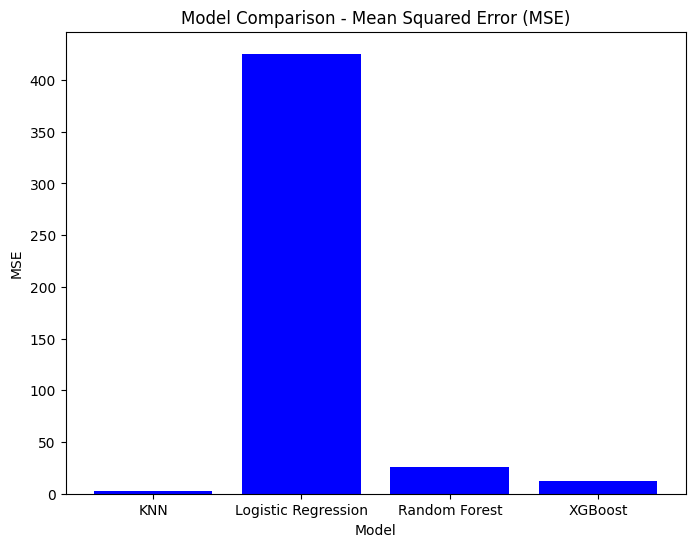

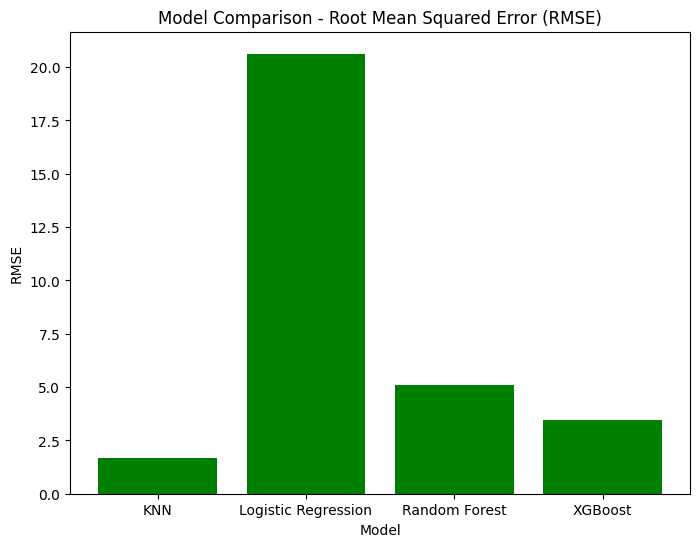

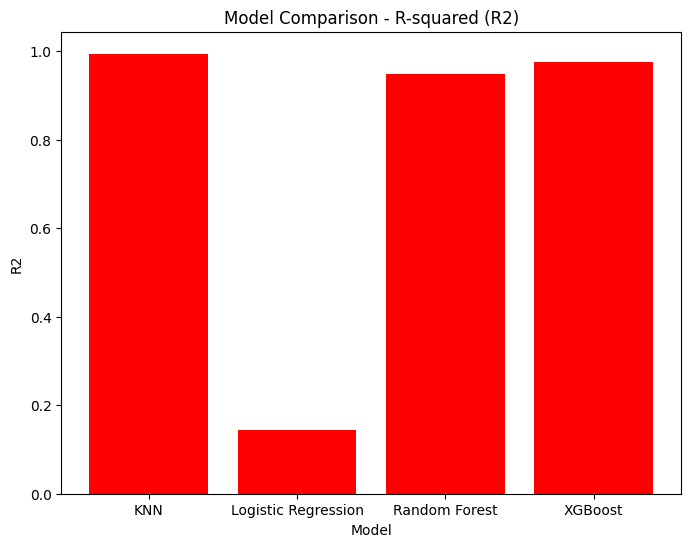

In [38]:
import matplotlib.pyplot as plt
import numpy as np

models = ['KNN', 'Logistic Regression', 'Random Forest', 'XGBoost']
mse_values = [mse_knn, mse_logistic, mse_rf, mse_xgb]
rmse_values = [rmse_knn, rmse_logistic, rmse_rf, rmse_xgb]
r2_values = [r2_knn, r2_logistic, r2_rf, r2_xgb]


plt.figure(figsize=(8, 6))
plt.bar(models, mse_values, color='blue')
plt.title('Model Comparison - Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()


plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color='green')
plt.title('Model Comparison - Root Mean Squared Error (RMSE)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()


plt.figure(figsize=(8, 6))
plt.bar(models, r2_values, color='red')
plt.title('Model Comparison - R-squared (R2)')
plt.xlabel('Model')
plt.ylabel('R2')
plt.show()